In [ ]:
pip install tensorflow

[INFO] loading CIFAR-10 dataset...
170498071/170498071 [==============================] - 4s 0us/step


[INFO] compiling model...
[INFO] training network...
Epoch 1/10
782/782 [==============================] - 21s 10ms/step - loss: 1.6402 - accuracy: 0.4421 - val_loss: 1.2504 - val_accuracy: 0.5446
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 1.1806 - accuracy: 0.5803 - val_loss: 1.1098 - val_accuracy: 0.5987
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 1.0242 - accuracy: 0.6373 - val_loss: 0.9999 - val_accuracy: 0.6476
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.9193 - accuracy: 0.6764 - val_loss: 1.2684 - val_accuracy: 0.5653
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.8419 - accuracy: 0.7028 - val_loss: 0.9797 - val_accuracy: 0.6593
Epoch 6/10
782/782 [==============================] - 8s 11ms/step - loss: 0.7714 - accuracy: 0.7304 - val_loss: 1.0185 - val_accuracy: 0.6506
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 0.7142 - accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step


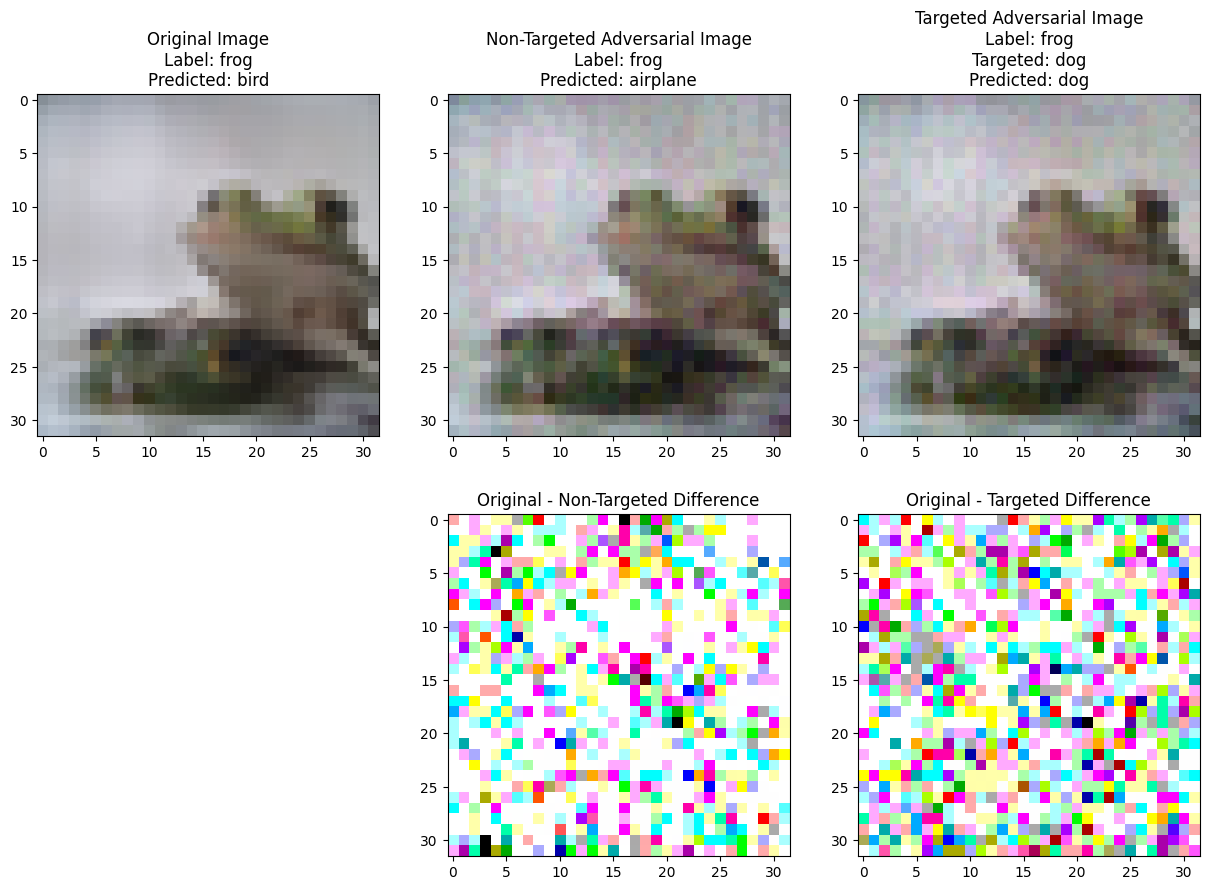

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# 간단한 CNN 모델 구축
class SimpleCNN:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

# 논타겟 공격 생성 클래스
class NonTargetedAdversarialGenerator:
    @staticmethod
    def bim(model, image, label, num_iter, alpha, eps=0.03):
        x_adv = tf.identity(image)
        label = tf.argmax(tf.cast(label, tf.float32), axis=1)

        for i in range(num_iter):
            with tf.GradientTape() as tape:
                tape.watch(x_adv)
                predictions = model(x_adv)
                loss = tf.keras.losses.sparse_categorical_crossentropy(label, predictions)
            gradient = tape.gradient(loss, x_adv)
            x_adv = x_adv + alpha * tf.sign(gradient)
            x_adv = tf.clip_by_value(x_adv, image - eps, image + eps)
        return x_adv

# 타겟 공격 생성 클래스
class TargetedAdversarialGenerator:
    @staticmethod
    def bim(model, image, target_label, num_iter, alpha, eps=0.03):
        x_adv = tf.identity(image)
        target_label = tf.argmax(tf.cast(target_label, tf.float32), axis=1)

        for i in range(num_iter):
            with tf.GradientTape() as tape:
                tape.watch(x_adv)
                predictions = model(x_adv)
                loss = -tf.keras.losses.sparse_categorical_crossentropy(target_label, predictions)
            gradient = tape.gradient(loss, x_adv)
            x_adv = x_adv + alpha * tf.sign(gradient)
            x_adv = tf.clip_by_value(x_adv, image - eps, image + eps)
        return x_adv

# CIFAR-10 데이터셋 로드 및 전처리
class CIFAR10Dataset:
    def __init__(self):
        self.trainX, self.trainY, self.testX, self.testY = self.load_cifar10_data()

    def load_cifar10_data(self):
        print("[INFO] loading CIFAR-10 dataset...")
        (trainX, trainY), (testX, testY) = cifar10.load_data()
        trainX = trainX / 255.0
        testX = testX / 255.0
        trainY = to_categorical(trainY, 10)
        testY = to_categorical(testY, 10)
        return trainX, trainY, testX, testY

# 모델 트레이너 클래스
class ModelTrainer:
    def __init__(self):
        self.model = None

    def build_model(self, width, height, depth, classes):
        self.model = SimpleCNN.build(width, height, depth, classes)

    def compile_model(self, learning_rate=1e-3):
        print("[INFO] compiling model...")
        opt = Adam(lr=learning_rate)
        self.model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    def train_model(self, trainX, trainY, testX, testY, batch_size=64, epochs=10):
        print("[INFO] training network...")
        self.model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=batch_size, epochs=epochs, verbose=1)

    def evaluate_model(self, testX, testY):
        loss, acc = self.model.evaluate(x=testX, y=testY, verbose=0)
        print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

    def save_model(self, model_path, weights_path):
        self.model.save(model_path)
        self.model.save_weights(weights_path)

    def load_model(self, model_path, weights_path):
        self.model = tf.keras.models.load_model(model_path)
        self.model.load_weights(weights_path)

# 메인 코드
if __name__ == "__main__":
    # CIFAR-10 데이터셋 로드
    dataset = CIFAR10Dataset()

    # 모델 트레이너 초기화 및 모델 빌드
    trainer = ModelTrainer()
    trainer.build_model(width=32, height=32, depth=3, classes=10)

    # 모델 컴파일 및 학습
    trainer.compile_model(learning_rate=1e-3)
    trainer.train_model(dataset.trainX, dataset.trainY, dataset.testX, dataset.testY, batch_size=64, epochs=10)

    # 모델 평가
    trainer.evaluate_model(dataset.testX, dataset.testY)

    # 모델 및 가중치 저장
    trainer.save_model("cnn_model.h5", "cnn_weights.h5")

    # 모델 및 가중치 로드
    trainer.load_model("cnn_model.h5", "cnn_weights.h5")

    # 비 타겟 공격 생성
    num_images = dataset.testX.shape[0]
    image_idx = np.random.randint(num_images)
    image = np.expand_dims(dataset.testX[image_idx], axis=0)
    label = np.expand_dims(dataset.testY[image_idx], axis=0)
    non_target_adv_gen = NonTargetedAdversarialGenerator()
    adv_image = non_target_adv_gen.bim(trainer.model, image, label, num_iter=10, alpha=0.01, eps=0.03)

    # 타겟 공격 생성
    target_label = to_categorical(np.array([5]), num_classes=10)
    target_adv_gen = TargetedAdversarialGenerator()
    target_adv_image = target_adv_gen.bim(trainer.model, image, target_label, num_iter=10, alpha=0.01, eps=0.03)

    # 원본 이미지와 적대적 이미지 모델 예측 결과
    original_pred = trainer.model.predict(image)
    non_target_adv_pred = trainer.model.predict(adv_image)
    target_adv_pred = trainer.model.predict(target_adv_image)
    original_class = np.argmax(original_pred)
    non_target_adv_class = np.argmax(non_target_adv_pred)
    target_adv_class = np.argmax(target_adv_pred)

    # CIFAR-10 클래스 레이블
    class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

    # 원본 이미지, 비타겟 적대적 이미지, 타겟 적대적 이미지 시각화
    plt.figure(figsize=(15, 10))

    # 원본 이미지
    plt.subplot(2, 3, 1)
    plt.title(f"Original Image\nLabel: {class_labels[np.argmax(label)]}\nPredicted: {class_labels[original_class]}")
    plt.imshow(image[0])

    # 비타겟 적대적 이미지
    plt.subplot(2, 3, 2)
    plt.title(f"Non-Targeted Adversarial Image\nLabel: {class_labels[np.argmax(label)]}\nPredicted: {class_labels[non_target_adv_class]}")
    plt.imshow(adv_image[0])

    # 타겟 적대적 이미지
    plt.subplot(2, 3, 3)
    plt.title(f"Targeted Adversarial Image\nLabel: {class_labels[np.argmax(label)]}\nTargeted: {class_labels[5]}\nPredicted: {class_labels[target_adv_class]}")
    plt.imshow(target_adv_image[0])

    # 원본 이미지와 비타겟 적대적 이미지 차이
    plt.subplot(2, 3, 5)
    plt.title("Original - Non-Targeted Difference")
    diff1 = np.abs(image[0] - adv_image[0])
    diff1 = (diff1 - diff1.min()) / (diff1.max() - diff1.min())  # Normalize the difference
    plt.imshow(diff1, cmap='hot')

    # 원본 이미지와 타겟 적대적 이미지 차이
    plt.subplot(2, 3, 6)
    plt.title("Original - Targeted Difference")
    diff2 = np.abs(image[0] - target_adv_image[0])
    diff2 = (diff2 - diff2.min()) / (diff2.max() - diff2.min())  # Normalize the difference
    plt.imshow(diff2, cmap='hot')

    plt.show()


In [ ]:
plt.subplot(2, 3, 5)
plt.title("Original - Non-Targeted Difference")
diff1 = np.abs(image[0] - adv_image[0])
diff1 = (diff1 - diff1.min()) / (diff1.max() - diff1.min())  # Normalize the difference
plt.imshow(diff1)

# 원본 이미지와 타겟 적대적 이미지 차이
plt.subplot(2, 3, 6)
plt.title("Original - Targeted Difference")
diff2 = np.abs(image[0] - target_adv_image[0])
diff2 = (diff2 - diff2.min()) / (diff2.max() - diff2.min())  # Normalize the difference
plt.imshow(diff2)

plt.show()